# 1. 데이터 로드

### import 할것들 미리 해두기

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import timedelta as td

In [2]:
import utils

### 경로 등 global config 설정

In [3]:
RAW_ROOT = 'raw'
DATA_ROOT = 'data'

### 원본 데이터 불러오기

In [4]:
%%time
_, _, df_log_raw, _ = utils.load_raw(RAW_ROOT)

CPU times: user 12.9 s, sys: 8.2 s, total: 21.1 s
Wall time: 20 s


---

# 2. 로그 데이터 확인 및 기본 전처리

### 데이터 확인

In [5]:
df_log_raw

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1


### 빠른 날짜 처리

In [6]:
df_log_raw['t_dat'][0]

'2018-09-20'

In [7]:
df_log = df_log_raw.copy()

In [8]:
%%time
dts_to_dto_map = {}
dts_to_ts_map = {}
for dts in df_log_raw['t_dat'].unique():
    dto = dt.strptime(dts, '%Y-%m-%d')
    dts_to_dto_map[dts] = dto
    dts_to_ts_map[dts] = int(dto.timestamp())

CPU times: user 1.53 s, sys: 148 ms, total: 1.68 s
Wall time: 1.67 s


In [9]:
%%time
df_log['timestamp'] = df_log_raw['t_dat'].map(dts_to_ts_map)
df_log['dto'] = df_log_raw['t_dat'].map(dts_to_dto_map)

CPU times: user 2.72 s, sys: 327 ms, total: 3.05 s
Wall time: 3.04 s


In [10]:
%%time
df_log['week'] = 104 - (df_log['dto'].max() - df_log['dto']).dt.days // 7

CPU times: user 878 ms, sys: 463 ms, total: 1.34 s
Wall time: 1.18 s


In [11]:
df_log['timestamp'][0]

1537369200

In [12]:
df_log['dto'][0]

Timestamp('2018-09-20 00:00:00')

In [13]:
df_log['week'][0]

0

In [14]:
df_log['week'].max()

104

In [15]:
del df_log_raw

### 가격 관련

분포 확인

CPU times: user 3.05 s, sys: 701 ms, total: 3.75 s
Wall time: 3.75 s


<AxesSubplot:ylabel='Frequency'>

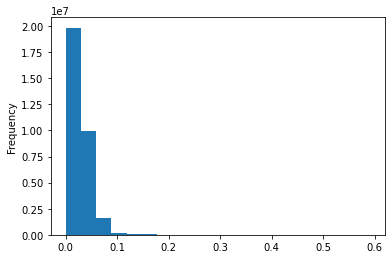

In [16]:
%%time
df_log['price'].plot.hist(bins=20)

혹시 로그라면?

CPU times: user 3.56 s, sys: 718 ms, total: 4.28 s
Wall time: 4.27 s


<AxesSubplot:ylabel='Frequency'>

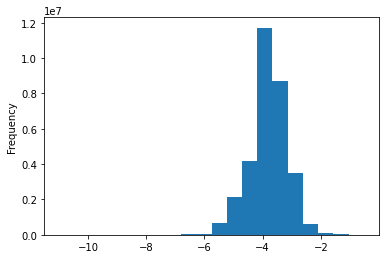

In [17]:
%%time
np.log(df_log['price']).plot.hist(bins=20)

로그 씌운 버전을, z-score로 바꿔서 필드에 추가 (non-linear니까)

In [18]:
log_price = np.log(df_log['price'])
mu = log_price.mean()
sigma = log_price.std()

In [19]:
df_log['log_price'] = (log_price - mu) / sigma

### 저장

여기까지 한것 확인

In [20]:
df_log

,t_dat,customer_id,article_id,price,sales_channel_id,timestamp,dto,week,log_price
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,1537369200,2018-09-20,0,1.231676
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,1537369200,2018-09-20,0,0.446524
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2,1537369200,2018-09-20,0,-0.619252
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2,1537369200,2018-09-20,0,-0.457210
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2,1537369200,2018-09-20,0,-0.457210
...,...,...,...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2,1600700400,2020-09-22,104,1.468579
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2,1600700400,2020-09-22,104,0.951462
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1,1600700400,2020-09-22,104,0.981898
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1,1600700400,2020-09-22,104,-1.867268


In [21]:
%%time
df_log.to_parquet(f'{DATA_ROOT}/df_log_preprocessed.pq')

CPU times: user 14.1 s, sys: 3.13 s, total: 17.2 s
Wall time: 16.7 s


In [22]:
del df_log

---

# 3. 기타

### 날짜 자르기 확인용

In [23]:
%%time
df_log = pd.read_parquet(f'{DATA_ROOT}/df_log_preprocessed.pq')

CPU times: user 12.1 s, sys: 7.45 s, total: 19.6 s
Wall time: 16.8 s


In [24]:
df_log['t_dat']

0           2018-09-20
1           2018-09-20
2           2018-09-20
3           2018-09-20
4           2018-09-20
               ...    
31788319    2020-09-22
31788320    2020-09-22
31788321    2020-09-22
31788322    2020-09-22
31788323    2020-09-22
Name: t_dat, Length: 31788324, dtype: object

LB의 valid 마지막인 `2020-09-22`에 대응 되는 작년 날짜 (즉, CV의 valid 끝): `2019-09-24`

시작 날짜부터 `2019-09-24`까지의 기간

In [25]:
dt(2019, 9, 24) - dt(2018, 9, 20)

datetime.timedelta(days=369)

따라서 LB를 CV의 기간 만큼만 사용할거라면 동일하게 계산되는 timedelta의 날짜를 써야함

In [26]:
dt(2020, 9, 22) - td(days=369)

datetime.datetime(2019, 9, 19, 0, 0)

### 정리

모두 inclusive

#### CV

* train: `2018-09-20` ~ `2019-09-17` (week 0 ~ 51)
* valid: `2019-09-18` ~ `2019-09-24` (week 52)
* test : `2019-09-25` ~ `2019-10-01` (week 53)

#### LB

* train: `2019-09-19` ~ `2020-09-15` (week 52 ~ 103)
* valid: `2020-09-16` ~ `2020-09-22` (week 104)
* test : `2020-09-23` ~ `2020-09-29` (week 105, unknown)

In [27]:
del df_log